## Using multiple strides in treadmill-acquired gait data for Multiple Sclerosis prediction 
### Extracting and low dimensional vizualizations for the last layer features from the best task generalization model (MSResnet)
* This analysis is only done on regress-N data and best task gen model (for the regress-N data)
* Best task gen model for regress-N data is MSResnet 

Reference: https://towardsdatascience.com/visualizing-feature-vectors-embeddings-using-pca-and-t-sne-ef157cea3a42



In [623]:
import sys
sys.path.append(r'D:\gait') #Because I am reading pickle file which is at a different folder

In [624]:
import torch
import torch.nn as nn
import numpy as np
import pickle
from torchinfo import summary
from utils.utils_lstm import read_data, genTTSequences, custom_StandardScaler
# %matplotlib widget
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import decomposition, manifold
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import seaborn as sns
from IPython import display

In [625]:
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [626]:
#Reading the pretrained best Task gen MSResnet model 
path = "D:/gait/results/task_generalize_lstm/5strides/all/MSResNet/regressN/[person_1_stride_92]taskMSResNet12021_04_09-19_18_45_661246/model"
with open(path+'.pkl', 'rb') as f:
    model = pickle.load(f)

In [627]:
#Creating the new model class using the best task gen pretrained model 
#Note that the forward is exactly same as the best MSResnet's forward 
#Reference: https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b
class new_model_(nn.Module):
    def __init__(self):
        super().__init__()
        #Using the pretrained best model's module 
        self.pretrained = model.module_
        
    def forward(self,x):
        # At input, boody coords is shaped as batch_size x sequence length (time steps) x 36 features 
        #But for 1D CNN, the input should be shaped as batch_size x features/channels x time steps/sequence length
        x = x.permute(0,2,1)
        x0 = self.pretrained.conv1(x)
        x0 = self.pretrained.bn1(x0)
        x0 = self.pretrained.relu(x0)
        x = self.pretrained.layer3x3_1(x0)
        x = self.pretrained.layer3x3_2(x)
        x = self.pretrained.layer3x3_3(x)
        x = self.pretrained.maxpool3(x)

        y = self.pretrained.layer5x5_1(x0)
        y = self.pretrained.layer5x5_2(y)
        y = self.pretrained.layer5x5_3(y)
        y = self.pretrained.maxpool5(y)
        
        out = torch.cat([x, y], dim=1)
        out = out.squeeze()
        #Returning the last layer features before 
        #applying the last fully connected layer 
        return out

In [628]:
#Scaling data between 0 and 1
def min_max_scale(data):
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

In [629]:
#Reading the regress-N data 
data = read_data("D:/gait/data/mr_scaled_features_30controlsTrialW.csv", False)
strides_per_sequence = 5 #5 strides per sequence 

In [630]:
#Reading the regress-N training and testing datasets for the Task gen framework 
testStridesList, fullTestLabelsList, trainStridesList, fullTrainLabelsList = genTTSequences(data, strides_per_sequence = 5, skippedSteps = 2, data_stream = "all")
print("Test strides list shape: ", np.array(testStridesList).shape)
print("Train strides list shape: ", np.array(trainStridesList).shape)

ss = custom_StandardScaler(strides_per_sequence, np.array(testStridesList).shape[2])
ss.fit(np.array(testStridesList))

#Normalized data used for the model 
testStridesList_norm = ss.transform(np.array(testStridesList))
trainStridesList_norm = ss.transform(np.array(trainStridesList))

#Converting to torch tensor 
testStridesList_norm = torch.autograd.Variable(torch.tensor(np.array(testStridesList_norm))).float()

dropped sequences:  225
Test strides list shape:  (700, 5, 21)
Train strides list shape:  (736, 5, 21)
<class 'numpy.ndarray'>


In [631]:
#Running the best task gen pretrained model over the test set to extract 
#last layer features 
new_model = new_model_()
last_layer_features = new_model.forward(testStridesList_norm)
print (last_layer_features)

tensor([[0.0000, 0.0776, 0.0279,  ..., 0.0000, 0.6275, 0.3114],
        [0.0000, 0.1491, 0.0357,  ..., 0.0000, 0.5880, 0.3017],
        [0.0000, 0.2115, 0.0636,  ..., 0.0000, 0.3300, 0.5524],
        ...,
        [0.1499, 0.0713, 0.0594,  ..., 1.8722, 0.1394, 0.0897],
        [0.2715, 0.0232, 0.0338,  ..., 2.4992, 0.1200, 0.0674],
        [0.1949, 0.0651, 0.0408,  ..., 2.4967, 0.1071, 0.0596]],
       grad_fn=<SqueezeBackward0>)


In [632]:
last_layer_features = last_layer_features.detach().numpy()
df = pd.DataFrame(last_layer_features)
fullTestLabelsList = pd.DataFrame(fullTestLabelsList, columns = ['label', 'PID'])
df = pd.concat((df, fullTestLabelsList), axis = 1)

df['color'] = 'r' #Initially all red
df['color'][df[df['label']==0].index] = 'g' #Green for controls 

df.head()

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,label,PID,color
0,0.0,0.077593,0.027910,0.0,0.640115,0.008116,0.187190,0.000000,0.054613,0.142373,...,0.0,0.008098,0.000000,0.319856,0.0,0.627471,0.311440,0.0,200,g
1,0.0,0.149135,0.035747,0.0,0.625164,0.005592,0.479923,0.005429,0.097037,0.440493,...,0.0,0.014780,0.000000,0.305191,0.0,0.587971,0.301687,0.0,200,g
2,0.0,0.211511,0.063565,0.0,0.492725,0.002309,0.680639,0.000278,0.040585,0.608027,...,0.0,0.045859,0.015260,0.367851,0.0,0.330046,0.552437,0.0,200,g
3,0.0,0.229814,0.094947,0.0,0.498116,0.005555,0.740880,0.000000,0.049285,0.600428,...,0.0,0.060213,0.013077,0.356944,0.0,0.240488,0.605324,0.0,200,g
4,0.0,0.238307,0.067437,0.0,0.449910,0.001867,0.826718,0.001308,0.036066,0.701757,...,0.0,0.053478,0.006328,0.371449,0.0,0.377344,0.504022,0.0,200,g


In [633]:
#Reading the EDSS scores for PwMS 
edss= pd.read_csv('C:\\Users\\Rachneet Kaur\\Box\\GAIT\\edss.csv')
#Keeping edss of only the 17 PwMS subjects we have the raw data for 
edss = edss[edss['PID'].isin(df[df['label']==1]['PID'].unique())].reset_index().drop('index', axis =1)
df['edss'] = df['PID'].map(edss.set_index('PID')['EDSS'])

In [634]:
#Defining the color based on EDSS
df['edss_color'] = 'g' #All green/controls initially 
mild_color = 'yellow'
mild_to_moderate_color = 'plum'
moderate_color = 'tomato'

df['edss_edgecolor'] = 'darkgreen' #All green/controls initially 
mild_edgecolor = 'orange'
mild_to_moderate_edgecolor = 'deeppink'
moderate_edgecolor = 'red'

df['edss_color'][df['edss']<3] = mild_color #Mild edss
df['edss_color'][(df['edss']>=3) & (df['edss']<5)] = mild_to_moderate_color #Mild-to-moderate EDSS
df['edss_color'][(df['edss']>=5)] = moderate_color #Moderate EDSS

df['edss_edgecolor'][df['edss']<3] = mild_edgecolor #Mild edss
df['edss_edgecolor'][(df['edss']>=3) & (df['edss']<5)] = mild_to_moderate_edgecolor #Mild-to-moderate EDSS
df['edss_edgecolor'][(df['edss']>=5)] = moderate_edgecolor #Moderate EDSS

In [635]:
df['edss_marker'] = 'o' #All green/controls initially 
mild_marker = '^'
mild_to_moderate_marker = 's'
moderate_marker = 'o'

df['edss_marker'][df['edss']<3] = mild_marker #Mild edss
df['edss_marker'][(df['edss']>=3) & (df['edss']<5)] = mild_to_moderate_marker #Mild-to-moderate EDSS
df['edss_marker'][(df['edss']>=5)] = moderate_marker #Moderate EDSS

In [636]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,509,510,511,label,PID,color,edss,edss_color,edss_edgecolor,edss_marker
0,0.0,0.077593,0.027910,0.0,0.640115,0.008116,0.187190,0.000000,0.054613,0.142373,...,0.0,0.627471,0.311440,0.0,200,g,NaN,g,darkgreen,o
1,0.0,0.149135,0.035747,0.0,0.625164,0.005592,0.479923,0.005429,0.097037,0.440493,...,0.0,0.587971,0.301687,0.0,200,g,NaN,g,darkgreen,o
2,0.0,0.211511,0.063565,0.0,0.492725,0.002309,0.680639,0.000278,0.040585,0.608027,...,0.0,0.330046,0.552437,0.0,200,g,NaN,g,darkgreen,o
3,0.0,0.229814,0.094947,0.0,0.498116,0.005555,0.740880,0.000000,0.049285,0.600428,...,0.0,0.240488,0.605324,0.0,200,g,NaN,g,darkgreen,o
4,0.0,0.238307,0.067437,0.0,0.449910,0.001867,0.826718,0.001308,0.036066,0.701757,...,0.0,0.377344,0.504022,0.0,200,g,NaN,g,darkgreen,o


In [637]:
print ((last_layer_features<0).sum())
data_to_reduce = last_layer_features
print ('Dimesions for original last layer test set features: ', data_to_reduce.shape)
data_to_reduce_normalized = StandardScaler().fit_transform(data_to_reduce)

normalize = False #Not normalizing last layer features before feeding to t-SNE 

0
Dimesions for original last layer test set features:  (700, 512)


In [719]:
def tsne_plot(perp = 30):
    #We will make 5 plots for eack t-SNE perp for analysis
    #1. HOA (green), PwMS(red): folder HOA_MS
    #2. HOA(green), PwMS distribution (red) - mild, mild-to-moderate, moderate in separate colors: folder HOA_MS_EDSS3classes
    #3. HOA(green), PwMS distribution (red) - mild + mild-to-moderate, moderate in separate colors: folder HOA_MS_EDSS2classes
    #4. HOA(green), mild, mild-to-moderate, moderate in separate colors dots and distributions: folder HOA_EDSS3classes 
    #5. HOA(green), mild + mild-to-moderate, moderate in separate colors dots and distributions: folder HOA_EDSS2classes

    #Non linear methods: t-SNE
    #t-SNE 
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perp, n_iter = 10000) #2D tsne 

    if normalize:
        tsne_2D = tsne.fit_transform(data_to_reduce_normalized)
    else:
        tsne_2D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_2D_normalized = np.concatenate((min_max_scale(tsne_2D[:, 0]), min_max_scale(tsne_2D[:, 1])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 2D = ', tsne.kl_divergence_, 'with perplexity = ', perp)


    # tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=30) #3D tsne 
    # tsne_3D = tsne.fit_transform(data_to_reduce)
    
    '''
    Plot 1: HOA (green), PwMS(red): folder HOA_MS
    '''
    df['edss_color'][df['edss']<3] = mild_color #Mild edss
    df['edss_color'][(df['edss']>=3) & (df['edss']<5)] = mild_to_moderate_color #Mild-to-moderate EDSS
    
    #2D t-SNE Scatter plot for HOA and MS 
    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax.scatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    plt.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 15);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tsne_2D: Original Labels")
    plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_MS\\tsne_2D_original_HOA_MS_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_)+'.png',dpi = 200)
    plt.close()
    
    
    tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['color'])
    tsne2D_added_colors.columns = ['tsnex', 'tsney']
    x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
    y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
    x_red =tsne2D_added_colors.loc[tsne2D_added_colors.index!='g']['tsnex'].values
    y_red = tsne2D_added_colors.loc[tsne2D_added_colors.index!='g']['tsney'].values

    #2D t-SNE scatter plot with joint and marginal distributions 
    ###Plotting with the distributions
    mpl.rcParams['axes.spines.top'] = True
    mpl.rcParams['axes.spines.right'] = True
    plt.rcParams['font.size'] = 15
    a = 0.2
    zo=0
    l=12
    p = sns.JointGrid(x = x_red, y = y_red, size = 7)
    p.x = list( x_red)
    p.y = list( y_red)
    p.plot_joint(plt.scatter, c=df['color'][df['color']!='g'], alpha = a)
    p.plot_marginals(sns.distplot, color='r', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
#     plt.grid()
    p.x = list( x_green)
    p.y = list( y_green)
    p.plot_joint(plt.scatter, c="g", alpha = a)
    p.plot_marginals(sns.distplot, color='g', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
#     plt.grid()
    p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
    # p.ax_joint.set_xticklabels([])
    # p.ax_joint.set_yticklabels([])
    # p.ax_marg_x.legend_.remove()
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    plt.legend((p1,p3), ('HOA','PwMS'), loc='upper right', fontsize = 15, bbox_to_anchor=(0.0, 1.0),)
    # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
    # plt.title('Trial W', fontsize = 14)
    plt.xlabel('x-axis', fontsize = 15)
    plt.ylabel('y-axis', fontsize = 15)
#     plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_MS\\tsne_2D_original_distributions_HOA_MS_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_) + '.png', dpi = 300)

    
    '''
    Plot 2: HOA(green), PwMS distribution (red) - mild, mild-to-moderate, moderate in separate colors: folder HOA_MS_EDSS3classes
    '''
    #2D t-SNE Scatter plot with 3 classes of EDSS added
    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
#     scatter = mscatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['edss_color'], m = ["d", "s", "o"], alpha =0.3, ax = ax)
    ax.scatter(tsne_2D_normalized[:, 0][df['edss_color']==mild_color], tsne_2D_normalized[:, 1][df['edss_color']==mild_color], color = 'r', alpha = 0.3, marker = '^', label = r'PwMS$_\mathrm{mild}$')
    ax.scatter(tsne_2D_normalized[:, 0][df['edss_color']==mild_to_moderate_color], tsne_2D_normalized[:, 1][df['edss_color']==mild_to_moderate_color], color = 'r', alpha = 0.5, marker = 's', label = r'PwMS$_{\mathrm{mild}\mathtt{-}\mathrm{mod}}$')
    ax.scatter(tsne_2D_normalized[:, 0][df['edss_color']==moderate_color], tsne_2D_normalized[:, 1][df['edss_color']==moderate_color], color = 'r', alpha = 0.7, marker = 'o', label = r'PwMS$_\mathrm{mod}$')
    ax.scatter(tsne_2D_normalized[:, 0][df['edss_color']=='g'], tsne_2D_normalized[:, 1][df['edss_color']=='g'], color = 'g', alpha = 0.5, marker = 'o', label = 'HOA')
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_color)
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_to_moderate_color)
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc=moderate_color)
    plt.legend(loc='best', fontsize = 13)
#     plt.legend((p1, p2, p3, p4), ('HOA', r'PwMS$_\mathrm{mild}$', r'PwMS$_{\mathrm{mild}\mathtt{-}\mathrm{mod}}$', r'PwMS$_\mathrm{mod}$'), loc='best', fontsize = 13);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tsne_2D: Original Labels")
    plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_MS_EDSS3classes\\tsne_2D_original_HOA_MS_EDSS3classes_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_)+ '.png',dpi = 200)
    plt.show()

    tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['edss_color'])
    tsne2D_added_colors.columns = ['tsnex', 'tsney']
    x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
    y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
    x_red =tsne2D_added_colors.loc[tsne2D_added_colors.index!='g']['tsnex'].values
    y_red = tsne2D_added_colors.loc[tsne2D_added_colors.index!='g']['tsney'].values

    #2D t-SNE scatter plot with joint and marginal distributions 
    ###Plotting with the distributions
    mpl.rcParams['axes.spines.top'] = True
    mpl.rcParams['axes.spines.right'] = True
    plt.rcParams['font.size'] = 15
    a = 0.2
    zo=0
    l=12
    p = sns.JointGrid(x = x_red, y = y_red, size = 7)
    p.x = list( x_red)
    p.y = list( y_red)
    p.plot_joint(mscatter, c=df['edss_color'][df['edss_color']!='g'], m = df['edss_marker'][df['edss_color']!='g'], s = 90, alpha = 0.5, edgecolors = df['edss_edgecolor'][df['edss_color']!='g'])
    p.plot_marginals(sns.distplot, color='r', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds", alpha = 1)
#     plt.grid()
    p.x = list( x_green)
    p.y = list( y_green)
    p.plot_joint(plt.scatter, c="g", alpha = 0.13, s= 90, edgecolors = df['edss_edgecolor'][df['edss_color']=='g'])
    p.plot_marginals(sns.distplot, color='g', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
#     plt.grid()
    p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
    # p.ax_joint.set_xticklabels([])
    # p.ax_joint.set_yticklabels([])
    # p.ax_marg_x.legend_.remove()
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green', label = 'HOA')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_color)
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_to_moderate_color)
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc=moderate_color)
    p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red', label = 'PwMS')
    mark1 = mpl.lines.Line2D([], [], marker="^", markersize=10, linewidth=0, color=mild_color, markeredgecolor = mild_edgecolor)
    mark2 = mpl.lines.Line2D([], [], marker="s", markersize=10, linewidth=0, color=mild_to_moderate_color, markeredgecolor = mild_to_moderate_edgecolor)
    mark3 = mpl.lines.Line2D([], [], marker="o", markersize=10, linewidth=0, color=moderate_color, markeredgecolor = moderate_edgecolor)
    mark4 = mpl.lines.Line2D([], [], color = 'white')
    plt.legend(handles = [p1, p5, mark4, mark1, mark2, mark3], labels = [ 'HOA', 'PwMS', '', r'PwMS$_\mathrm{mild}$', r'PwMS$_{\mathrm{mild}\mathtt{-}\mathrm{mod}}$', r'PwMS$_\mathrm{mod}$'], fontsize = 15, ncol = 2, loc='upper left', bbox_to_anchor=(-4.3, 0.22), columnspacing = 0.6, labelspacing = 0.3);
    # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
    # plt.title('Trial W', fontsize = 14)
    
#     patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
#             label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
#     plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.5), 
#            loc='center', ncol=2, facecolor="plum", numpoints=1 )


    plt.xlabel('x-axis', fontsize = 15)
    plt.ylabel('y-axis', fontsize = 15)
#     plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_MS_EDSS3classes\\tsne_2D_original_distributions_HOA_MS_EDSS3classes_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_) + '.png', dpi = 300,  bbox_inches='tight')




## t-SNE


KL divergence for t-SNE 2D =  0.23595845699310303 with perplexity =  72


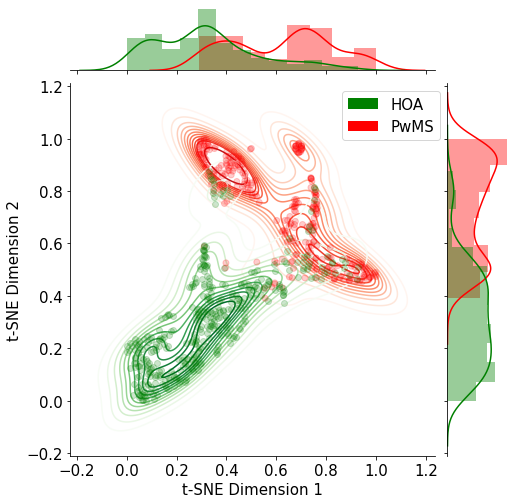

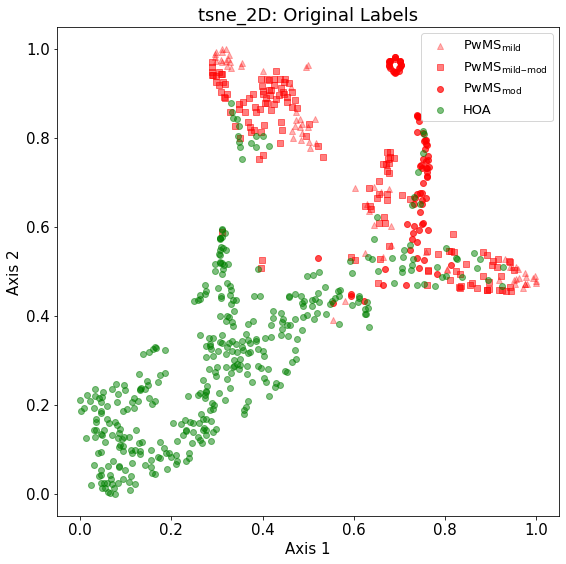

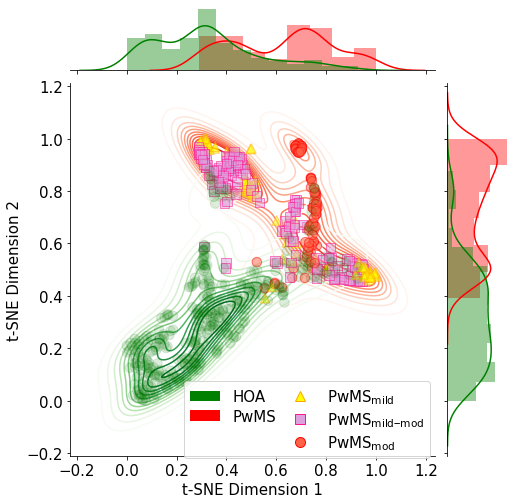

In [720]:
for p in [72]: #[30, 35, 40, 45, 50, 55, 60, 63, 65, 68, 70, 72, 73, 75, 78, 80, 85, 90, 100]:
    tsne_plot(p)

## 3D t-SNE

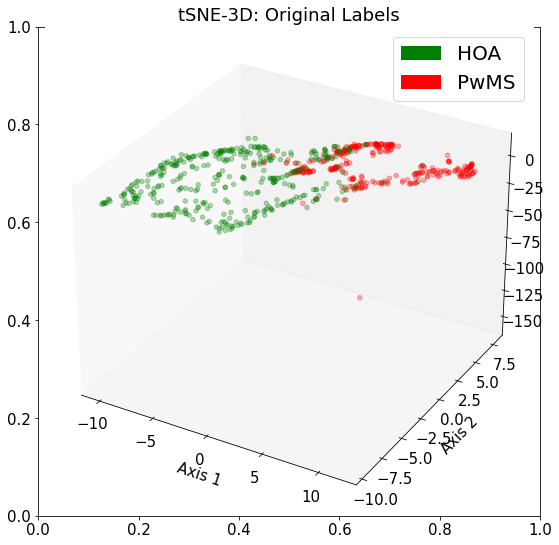

In [191]:
#3D t-SNE 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax = plt.axes(projection='3d')
ax.scatter3D(tsne_3D[:, 0], tsne_3D[:, 1], tsne_3D[:, 2], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
# p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("tSNE-3D: Original Labels")
plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\tsne3D_original.png',dpi = 200)

## NMF

In [ ]:
# #Linear methods: NMF/PCA/ICA
# # NMF
# model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
# NMF_2D = model_NMF.fit_transform(data_to_reduce)
# df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

# model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
# NMF_3D = model_NMF3.fit_transform(data_to_reduce)
# df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

# # PCA
# model_pca = decomposition.PCA(n_components=2)
# PCA_2D = model_pca.fit_transform(data_to_reduce)
# df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

# model_pca = decomposition.PCA(n_components=3)
# PCA_3D = model_pca.fit_transform(data_to_reduce)
# df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

# # ICA
# model_ICA = decomposition.FastICA(n_components=2)
# ICA_2D = model_ICA.fit_transform(data_to_reduce)
# model_ICA = decomposition.FastICA(n_components=3)
# ICA_3D = model_ICA.fit_transform(data_to_reduce)

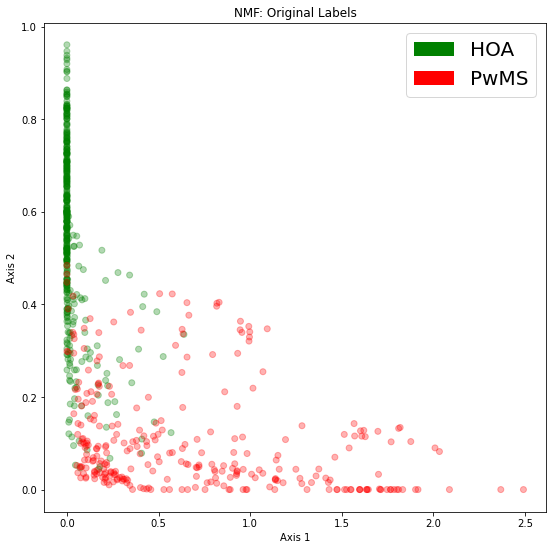

In [45]:
#2D NMF scatter plot 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax.scatter(NMF_2D[:, 0], NMF_2D[:, 1], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("NMF: Original Labels")
plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\NMF2D_original.png',dpi = 200)

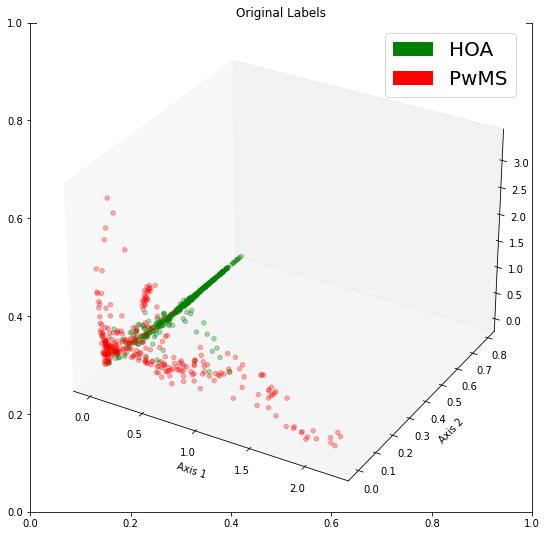

In [305]:
#3D NMF 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax = plt.axes(projection='3d')
ax.scatter3D(NMF_3D[:, 0], NMF_3D[:, 1], NMF_3D[:, 2], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
# p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("Original Labels")
plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\NMF3D_original.png',dpi = 200)

## PCA

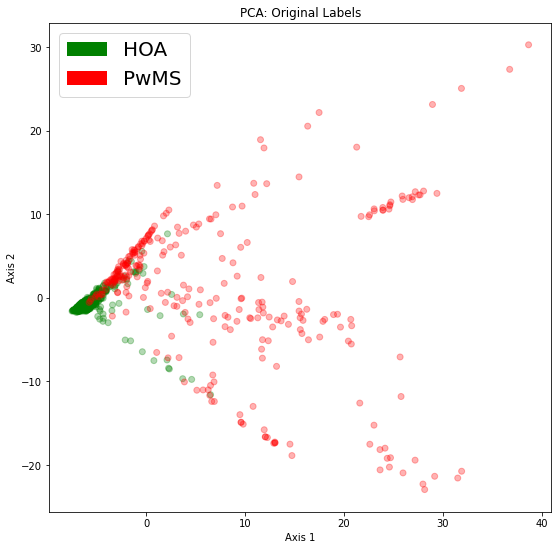

In [306]:
#2D PCA 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax.scatter(PCA_2D[:, 0], PCA_2D[:, 1], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("PCA: Original Labels")
plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\PCA2D_original.png',dpi = 200)

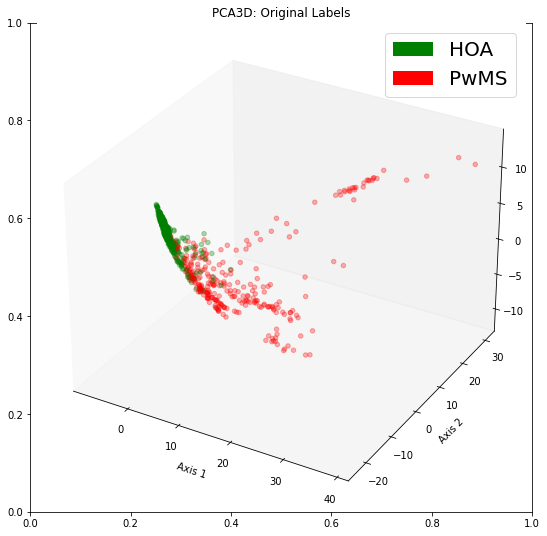

In [310]:
#3D PCA
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax = plt.axes(projection='3d')
ax.scatter3D(PCA_3D[:, 0], PCA_3D[:, 1], PCA_3D[:, 2], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
# p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("PCA3D: Original Labels")
plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\PCA3D_original.png',dpi = 200)

## ICA

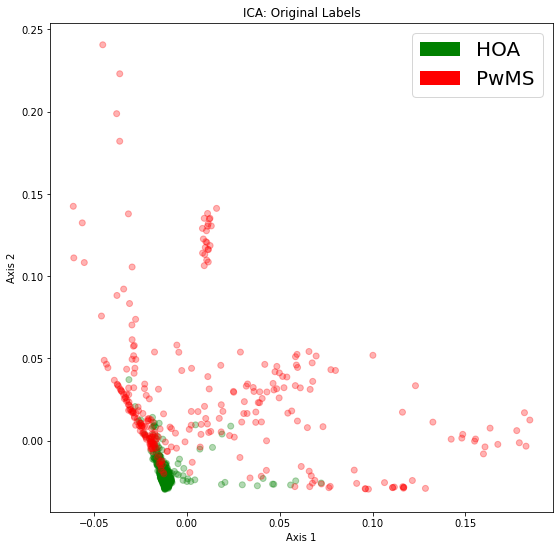

In [308]:
#2D ICA 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax.scatter(ICA_2D[:, 0], ICA_2D[:, 1], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("ICA: Original Labels")
plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\ICA2D_original.png',dpi = 200)

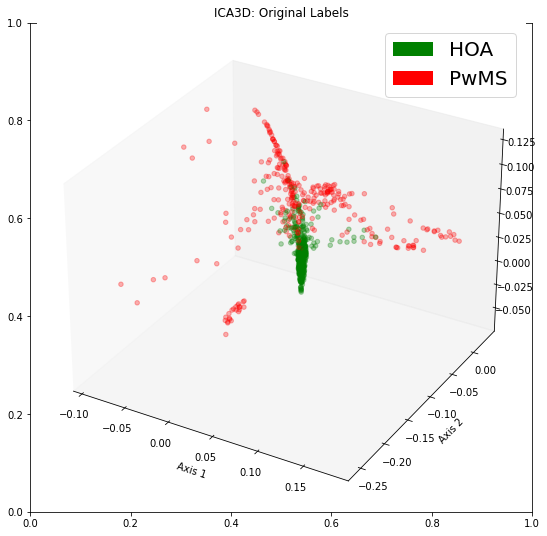

In [311]:
#3D ICA 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax = plt.axes(projection='3d')
ax.scatter3D(ICA_3D[:, 0], ICA_3D[:, 1], ICA_3D[:, 2], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
# p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("ICA3D: Original Labels")
plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\ICA3D_original.png',dpi = 200)

### Extra t-SNE plots

In [ ]:

#     '''
#     Plot 4: HOA(green), mild, mild-to-moderate, moderate in separate colors dots and distributions: folder HOA_EDSS3classes 
#     '''
#     #2D t-SNE Scatter plot with 3 classes of EDSS added
#     f = plt.figure(figsize=(9, 9))
#     ax = f.add_subplot(1, 1, 1)
#     ax.scatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['edss_color'], alpha =0.3)
#     p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
#     p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_color)
#     p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_to_moderate_color)
#     p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc=moderate_color)
#     plt.legend((p1, p2, p3, p4), ('HOA',r'PwMS$_\mathrm{mild}$', r'PwMS$_{\mathrm{mild}\mathtt{-}\mathrm{mod}}$', r'PwMS$_\mathrm{mod}$'), loc='best', fontsize = 13);
#     ax.grid(False)
#     ax.set_xlabel('Axis 1')
#     ax.set_ylabel('Axis 2')
#     ax.set_title("tsne_2D: Original Labels")
#     plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_EDSS3classes\\tsne_2D_original_HOA_MS_EDSS3classes_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_)+ '.png',dpi = 200)
#     plt.close()
    

#     tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['edss_color'])
#     tsne2D_added_colors.columns = ['tsnex', 'tsney']
#     x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
#     y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
#     x_mild =tsne2D_added_colors.loc[tsne2D_added_colors.index==mild_color]['tsnex'].values
#     y_mild = tsne2D_added_colors.loc[tsne2D_added_colors.index==mild_color]['tsney'].values
#     x_mild_to_moderate =tsne2D_added_colors.loc[tsne2D_added_colors.index==mild_to_moderate_color]['tsnex'].values
#     y_mild_to_moderate = tsne2D_added_colors.loc[tsne2D_added_colors.index==mild_to_moderate_color]['tsney'].values
#     x_moderate =tsne2D_added_colors.loc[tsne2D_added_colors.index==moderate_color]['tsnex'].values
#     y_moderate = tsne2D_added_colors.loc[tsne2D_added_colors.index==moderate_color]['tsney'].values
    
#     #2D t-SNE scatter plot with joint and marginal distributions 
#     ###Plotting with the distributions
#     mpl.rcParams['axes.spines.top'] = True
#     mpl.rcParams['axes.spines.right'] = True
#     plt.rcParams['font.size'] = 15
#     a = 0.2
#     zo=0
#     l=12
#     p = sns.JointGrid(x = x_mild, y = y_mild, size = 7)
#     p.x = list( x_mild)
#     p.y = list( y_mild)
#     p.plot_joint(plt.scatter, c=df['edss_color'][df['edss_color']==mild_color], alpha = a)
# #     p.plot_marginals(sns.distplot, color=mild_color, axlabel=[])
#     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Oranges")
# #     plt.grid()
#     p.x = list( x_green)
#     p.y = list( y_green)
#     p.plot_joint(plt.scatter, c="g", alpha = a)
# #     p.plot_marginals(sns.distplot, color='g', axlabel=[])
#     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
# #     plt.grid()
#     p.x = list( x_mild_to_moderate)
#     p.y = list( y_mild_to_moderate)
#     p.plot_joint(plt.scatter, c=mild_to_moderate_color, alpha = a)
# #     p.plot_marginals(sns.distplot, color=mild_to_moderate_color, axlabel=[])
#     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")
#     p.x = list( x_moderate)
#     p.y = list( y_moderate)
#     p.plot_joint(plt.scatter, c=moderate_color, alpha = a)
# #     p.plot_marginals(sns.distplot, color=moderate_color, axlabel=[])
#     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="RdPu")
#     p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
#     # p.ax_joint.set_xticklabels([])
#     # p.ax_joint.set_yticklabels([])
#     # p.ax_marg_x.legend_.remove()
#     p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
#     p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_color)
#     p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_to_moderate_color)
#     p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc=moderate_color)
#     p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
#     plt.legend((p1, p2, p3, p4), ('HOA', r'PwMS$_\mathrm{mild}$', r'PwMS$_{\mathrm{mild}\mathtt{-}\mathrm{mod}}$', r'PwMS$_\mathrm{mod}$'), loc='best', fontsize = 13);
#     # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
#     # plt.title('Trial W', fontsize = 14)
#     plt.xlabel('x-axis', fontsize = 15)
#     plt.ylabel('y-axis', fontsize = 15)
# #     plt.grid(linestyle='--')
#     plt.tight_layout()
#     plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_EDSS3classes\\tsne_2D_original_distributions_HOA_EDSS3classes_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_) + '.png', dpi = 300)

    
    
#     '''
#     Plot 3: HOA(green), PwMS distribution (red) - mild + mild-to-moderate, moderate in separate colors: folder HOA_MS_EDSS2classes
#     '''
    
#     df['edss_color'][df['edss']<5] = mild_color #Merging mild and mild-to-moderate PwMS in one group

#     #2D t-SNE Scatter plot with 2 classes of EDSS added
#     f = plt.figure(figsize=(9, 9))
#     ax = f.add_subplot(1, 1, 1)
#     ax.scatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['edss_color'], alpha =0.3)
#     p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
#     p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_color) #Merging mild and mild-to-moderate PwMS in one group
#     p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_to_moderate_color)
#     p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc=moderate_color)
#     plt.legend((p1, p2, p4), ('HOA', r'PwMS$_{\mathrm{mild}\mathtt{-}\mathrm{mod}}$', r'PwMS$_\mathrm{mod}$'), loc='best', fontsize = 13);
#     ax.grid(False)
#     ax.set_xlabel('Axis 1')
#     ax.set_ylabel('Axis 2')
#     ax.set_title("tsne_2D: Original Labels")
#     plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_MS_EDSS2classes\\tsne_2D_original_HOA_MS_EDSS2classes_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_)+ '.png',dpi = 200)
#     plt.close()
    

#     tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['edss_color'])
#     tsne2D_added_colors.columns = ['tsnex', 'tsney']
#     x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
#     y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
#     x_red =tsne2D_added_colors.loc[tsne2D_added_colors.index!='g']['tsnex'].values
#     y_red = tsne2D_added_colors.loc[tsne2D_added_colors.index!='g']['tsney'].values

#     #2D t-SNE scatter plot with joint and marginal distributions 
#     ###Plotting with the distributions
#     mpl.rcParams['axes.spines.top'] = True
#     mpl.rcParams['axes.spines.right'] = True
#     plt.rcParams['font.size'] = 15
#     a = 0.2
#     zo=0
#     l=12
#     p = sns.JointGrid(x = x_red, y = y_red, size = 7)
#     p.x = list( x_red)
#     p.y = list( y_red)
#     p.plot_joint(plt.scatter, c=df['edss_color'][df['edss_color']!='g'], alpha = 0.3)
#     p.plot_marginals(sns.distplot, color='r', axlabel=[])
#     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds", alpha = 0.5)
# #     plt.grid()
#     p.x = list( x_green)
#     p.y = list( y_green)
#     p.plot_joint(plt.scatter, c="g", alpha = a)
#     p.plot_marginals(sns.distplot, color='g', axlabel=[])
#     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
# #     plt.grid()
#     p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
#     # p.ax_joint.set_xticklabels([])
#     # p.ax_joint.set_yticklabels([])
#     # p.ax_marg_x.legend_.remove()
#     p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
#     p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_color)
#     p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_to_moderate_color)
#     p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc=moderate_color)
#     p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
#     plt.legend((p1, p5, p2, p4), ('HOA', 'PwMS', r'PwMS$_{\mathrm{mild}\mathtt{-}\mathrm{mod}}$', r'PwMS$_\mathrm{mod}$'), loc='best', fontsize = 13);
#     # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
#     # plt.title('Trial W', fontsize = 14)
#     plt.xlabel('x-axis', fontsize = 15)
#     plt.ylabel('y-axis', fontsize = 15)
# #     plt.grid(linestyle='--')
#     plt.tight_layout()
#     plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_MS_EDSS2classes\\tsne_2D_original_distributions_HOA_MS_EDSS2classes_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_) + '.png', dpi = 300)

    
#     '''
#     Plot 5: HOA(green), mild + mild-to-moderate, moderate in separate colors dots and distributions: folder HOA_EDSS2classes
#     '''
#     #2D t-SNE Scatter plot with 3 classes of EDSS added
#     f = plt.figure(figsize=(9, 9))
#     ax = f.add_subplot(1, 1, 1)
#     ax.scatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['edss_color'], alpha =0.3)
#     p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
#     p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_color)
#     p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_to_moderate_color)
#     p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc=moderate_color)
#     plt.legend((p1, p2, p4), ('HOA',r'PwMS$_{\mathrm{mild}\mathtt{-}\mathrm{mod}}$', r'PwMS$_\mathrm{mod}$'), loc='best', fontsize = 13);
#     ax.grid(False)
#     ax.set_xlabel('Axis 1')
#     ax.set_ylabel('Axis 2')
#     ax.set_title("tsne_2D: Original Labels")
#     plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_EDSS2classes\\tsne_2D_original_HOA_EDSS2classes_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_)+ '.png',dpi = 200)
#     plt.close()
    

#     tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['edss_color'])
#     tsne2D_added_colors.columns = ['tsnex', 'tsney']
#     x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
#     y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
#     #Since we have merged mild and mild-to-moderate as one group
#     x_mild =tsne2D_added_colors.loc[tsne2D_added_colors.index==mild_color]['tsnex'].values
#     y_mild = tsne2D_added_colors.loc[tsne2D_added_colors.index==mild_color]['tsney'].values
# #     x_mild_to_moderate =tsne2D_added_colors.loc[tsne2D_added_colors.index==mild_to_moderate_color]['tsnex'].values
# #     y_mild_to_moderate = tsne2D_added_colors.loc[tsne2D_added_colors.index==mild_to_moderate_color]['tsney'].values
#     x_moderate =tsne2D_added_colors.loc[tsne2D_added_colors.index==moderate_color]['tsnex'].values
#     y_moderate = tsne2D_added_colors.loc[tsne2D_added_colors.index==moderate_color]['tsney'].values
    
#     #2D t-SNE scatter plot with joint and marginal distributions 
#     ###Plotting with the distributions
#     mpl.rcParams['axes.spines.top'] = True
#     mpl.rcParams['axes.spines.right'] = True
#     plt.rcParams['font.size'] = 15
#     a = 0.2
#     zo=0
#     l=12
#     p = sns.JointGrid(x = x_mild, y = y_mild, size = 7)
#     p.x = list( x_mild)
#     p.y = list( y_mild)
#     p.plot_joint(plt.scatter, c=df['edss_color'][df['edss_color']==mild_color], alpha = a)
# #     p.plot_marginals(sns.distplot, color=mild_color, axlabel=[])
#     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Oranges")
# #     plt.grid()
#     p.x = list( x_green)
#     p.y = list( y_green)
#     p.plot_joint(plt.scatter, c="g", alpha = a)
# #     p.plot_marginals(sns.distplot, color='g', axlabel=[])
#     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
# #     plt.grid()
# #     p.x = list( x_mild_to_moderate)
# #     p.y = list( y_mild_to_moderate)
# #     p.plot_joint(plt.scatter, c=mild_to_moderate_color, alpha = a)
# #     p.plot_marginals(sns.distplot, color=mild_to_moderate_color, axlabel=[])
# #     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")
#     p.x = list( x_moderate)
#     p.y = list( y_moderate)
#     p.plot_joint(plt.scatter, c=moderate_color, alpha = a)
# #     p.plot_marginals(sns.distplot, color=moderate_color, axlabel=[])
#     p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="RdPu")
#     p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
#     # p.ax_joint.set_xticklabels([])
#     # p.ax_joint.set_yticklabels([])
#     # p.ax_marg_x.legend_.remove()
#     p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
#     p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_color)
#     p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc=mild_to_moderate_color)
#     p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc=moderate_color)
#     p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
#     plt.legend((p1, p2, p4), ('HOA', r'PwMS$_{\mathrm{mild}\mathtt{-}\mathrm{mod}}$', r'PwMS$_\mathrm{mod}$'), loc='best', fontsize = 13);
#     # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
#     # plt.title('Trial W', fontsize = 14)
#     plt.xlabel('x-axis', fontsize = 15)
#     plt.ylabel('y-axis', fontsize = 15)
# #     plt.grid(linestyle='--')
#     plt.tight_layout()
#     plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\HOA_EDSS2classes\\tsne_2D_original_distributions_HOA_EDSS2classes_' + str(perp) + 'KL_'+ str(tsne.kl_divergence_) + '.png', dpi = 300)